# <center>Anime Trends MCP</center>

### 1. Import Libraries and Setup Authentication

In [16]:
import os
from dotenv import load_dotenv
from huggingface_hub import login, hf_hub_download
import pandas as pd
import matplotlib.pyplot as plt
from collections import Counter
import seaborn as sns
import numpy as np


load_dotenv()
hf_token = os.getenv("HF_TOKEN")
login(token=hf_token)

Note: Environment variable`HF_TOKEN` is set and is the current active token independently from the token you've just configured.


### 2. Download Metadata Dataset

In [ ]:
print("Downloading metadata... (This may take a few minutes)")
file_path = hf_hub_download(
    repo_id="deepghs/danbooru2024-webp-4Mpixel", 
    filename="metadata.parquet",
    repo_type="dataset",
    local_dir="."
)
print(f"Success! Metadata saved to: {file_path}")

Success! Metadata saved to: metadata.parquet


### 3. Load Dataset and Create Character Popularity Lifecycle Chart

Loading dataset...
Processing Rem (Re:Zero)...
Processing Makima (Chainsaw Man)...
Processing Frieren...
Processing Hatsune Miku...
Processing Lucy (Cyberpunk)...


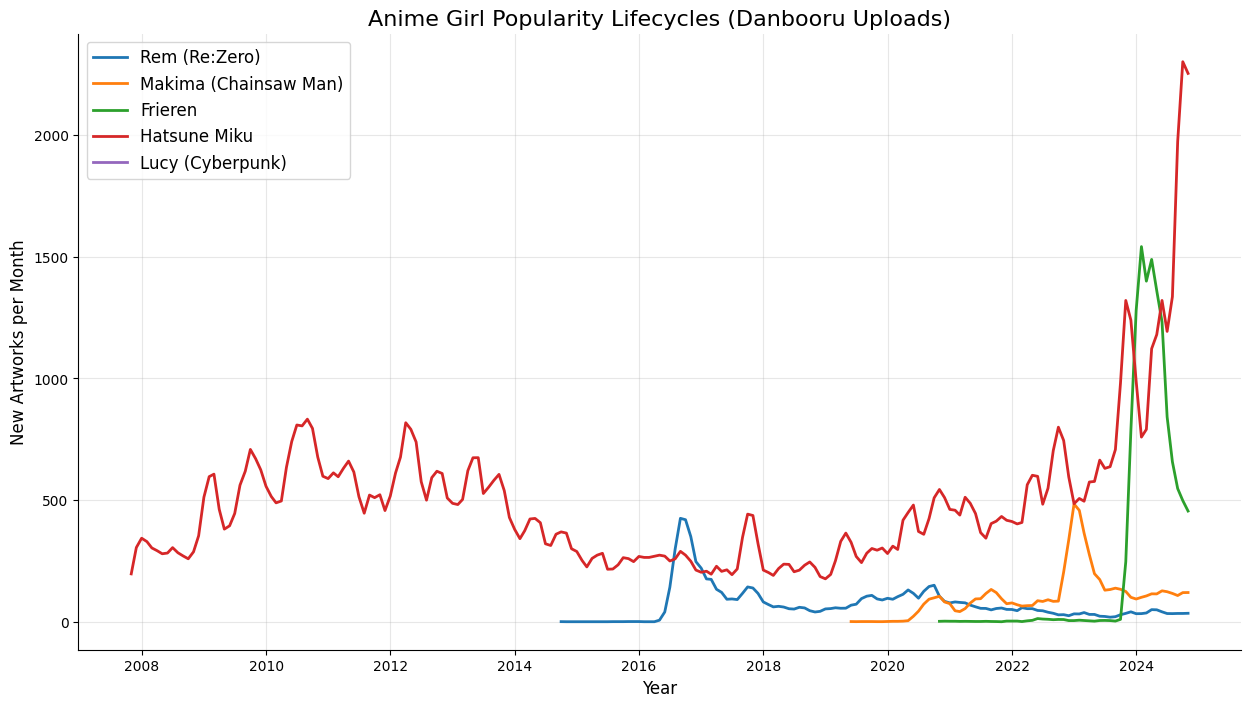

In [ ]:

# print("Loading dataset...")
df = pd.read_parquet("metadata.parquet", columns=["created_at", "tag_string"])

# utc=True handles the mixed timezones
df['created_at'] = pd.to_datetime(df['created_at'], utc=True)

# sample character list
characters = {
    "Rem (Re:Zero)": "rem_(re:zero)",
    "Makima (Chainsaw Man)": "makima_(chainsaw_man)",
    "Frieren": "frieren",
    "Hatsune Miku": "hatsune_miku",
    "Lucy (Cyberpunk)": "lucy_(cyberpunk_edgerunners)"
}


plt.figure(figsize=(15, 8))

for label, tag in characters.items():
    # print(f"Processing {label}...")
    
    # filtering for the specific tag
    mask = df['tag_string'].str.contains(tag, regex=False, na=False)
    
    # using 'ME' (Month End) instead of 'M' to silence the warning
    trend = df.loc[mask].set_index('created_at').resample('ME').size()
    trend = trend.rolling(window=3).mean()
    plt.plot(trend.index, trend.values, label=label, linewidth=2)

plt.title("Anime Girl Popularity Lifecycles (Danbooru Uploads)", fontsize=16)
plt.xlabel("Year", fontsize=12)
plt.ylabel("New Artworks per Month", fontsize=12)
plt.legend(fontsize=12)
plt.grid(True, alpha=0.3)
ax = plt.gca()
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
plt.show()

### 4. Analyze Trait Popularity Evolution

Processing trait: Maid Outfits...
Processing trait: School Uniforms...
Processing trait: Swimsuits...
Processing trait: Bunny Girls...
Processing trait: Cat Ears...


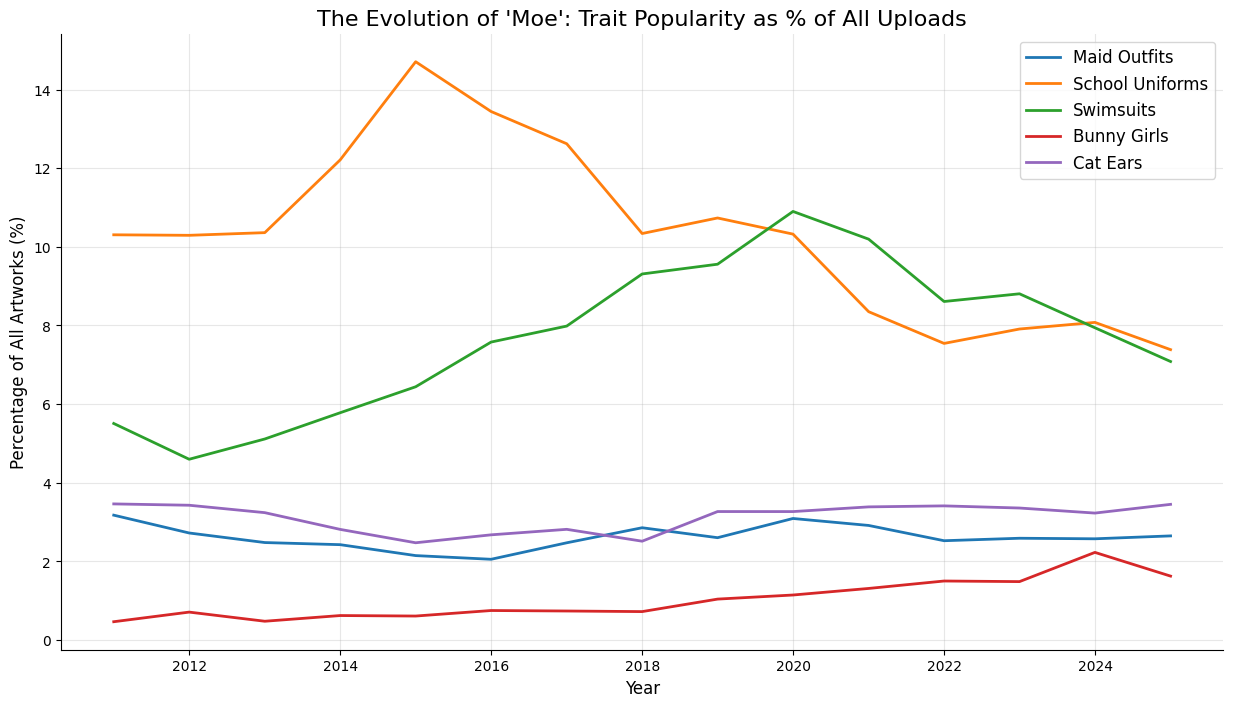

In [ ]:
traits = {
    "Maid Outfits": "maid",
    "School Uniforms": "school_uniform",
    "Swimsuits": "swimsuit",
    "Bunny Girls": "playboy_bunny",
    "Cat Ears": "cat_ears"
}

plt.figure(figsize=(15, 8))
for label, tag in traits.items():
    # print(f"Processing trait: {label}...")
    
    # filtering for the specific tag
    mask = df['tag_string'].str.contains(tag, regex=False, na=False)
    subset = df.loc[mask].set_index('created_at')
    
    # getting counts per year
    trait_counts = subset.resample('YE').size()
    total_counts = df.set_index('created_at').resample('YE').size()
    
    # getting percentage of popularity
    relative_popularity = (trait_counts / total_counts) * 100
    relative_popularity = relative_popularity['2010':'2024']
    plt.plot(relative_popularity.index, relative_popularity.values, label=label, linewidth=2)

plt.title("The Evolution of 'Moe': Trait Popularity as % of All Uploads", fontsize=16)
plt.xlabel("Year", fontsize=12)
plt.ylabel("Percentage of All Artworks (%)", fontsize=12)
plt.legend(fontsize=12)
plt.grid(True, alpha=0.3)
ax = plt.gca()
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
plt.show()

### 5. Find Top 10 Most Popular Characters by Year

In [11]:
SPECIFIC_BANS = {
    'star_(symbol)', 'star_(sky)', 'pom_pom_(clothes)', 'shrug_(clothing)',
    'poke_ball_(basic)', 'vision_(genshin_impact)', 'sensei_(blue_archive)',
    'idolmaster_(classic)', 'mahou_shoujo_madoka_magica_(anime)',
    'admiral_(kancolle)', 'producer_(idolmaster)', 'commander_(azur_lane)',
    'doctor_(arknights)', 'traveler_(genshin_impact)', 'trainer_(pokemon)',
    'summoner_(fire_emblem)', 'gudako_(fate/grand_order)', 'unknown_(series)',
    'check_commentary_(request)', 'translation_(request)', 'original_(character)',
    'spot_the_difference', 'comic', 'monochrome', 'heart', 'exclamation_point',
    'comic_koma', 'omake', '4koma', 'silent_comic'
}

BAD_SUFFIXES = (
    '_(series)', '_(medium)', '_(style)', '_(source)', 
    '_(cosplay)', '_(object)', '_(group)', '_(production)',
    '_(creature)', '_(game)', '_(request)', '_(event)', 
    '_(art_style)', '_(artist)', '_(lore)', '_(meta)',
    '_(costume)', '_(parody)'
)

VIPS = {
    'hatsune_miku', 'hakurei_reimu', 'kirisame_marisa', 
    'remilia_scarlet', 'flandre_scarlet', 'kochiya_sanae', 
    'izayoi_sakuya', 'konpaku_youmu', 'cirno', 'kagamine_rin'
}
print(f"{'Year':<6} | {'Top 10 Most Popular Characters':<80}")
print("-" * 100)

for year in range(2015, 2026):
    start_date = f"{year}-01-01"
    end_date = f"{year}-12-31"
    
    # filtering for the year AND '1girl' (to focus on characters)
    mask = (
        (df['created_at'] >= start_date) & 
        (df['created_at'] <= end_date) & 
        (df['tag_string'].str.contains('1girl', regex=False, na=False))
    )
    subset = df.loc[mask]
    
    if subset.empty:
        print(f"{year:<6} | No data found.")
        continue

    # counting tags
    all_tags = " ".join(subset['tag_string'].dropna()).split()
    counts = Counter(all_tags)
    
    top_chars = []
    
    for tag, count in counts.most_common(8000):
        if tag in SPECIFIC_BANS: continue
        
        is_vip = tag in VIPS
        has_parens = '_(' in tag and tag.endswith(')')
        
        if is_vip or has_parens:
            if not tag.endswith(BAD_SUFFIXES):
                # clean name for display: "rem_(re:zero)" -> "Rem"
                clean_name = tag.split('_(')[0].replace('_', ' ').title()
                top_chars.append(clean_name)
        
        if len(top_chars) == 10:
            break

    print(f"{year:<6} | {', '.join(top_chars)}")

Year   | Top 10 Most Popular Characters                                                  
----------------------------------------------------------------------------------------------------
2015   | Hatsune Miku, Hestia, Hakurei Reimu, Flandre Scarlet, Kirisame Marisa, Shimakaze, Remilia Scarlet, Kaga, Ro-500, Murakumo
2016   | Hatsune Miku, Kashima, Rem, Hamakaze, D.Va, Hakurei Reimu, Flandre Scarlet, Artoria Pendragon, Genderswap, Konpaku Youmu
2017   | Hatsune Miku, Artoria Pendragon, 2B, Nero Claudius, Tamamo, Hakurei Reimu, Jeanne D'Arc, Scathach, Serval, Jeanne D'Arc Alter
2018   | Zero Two, Artoria Pendragon, Hatsune Miku, Abigail Williams, Jeanne D'Arc Alter, Tamamo, Hiro, Nero Claudius, Scathach, Okita Souji
2019   | Hatsune Miku, Artoria Pendragon, Abigail Williams, Formidable, Jeanne D'Arc Alter, Marnie, Shigure, Tamamo, Scathach, Meltryllis
2020   | Hatsune Miku, Artoria Pendragon, Bremerton, Abigail Williams, Karyl, Manjuu, Sirius, Scathach, Genderswap, Mona
2021   | Gany

### 6. Character Co-occurrence Heatmap

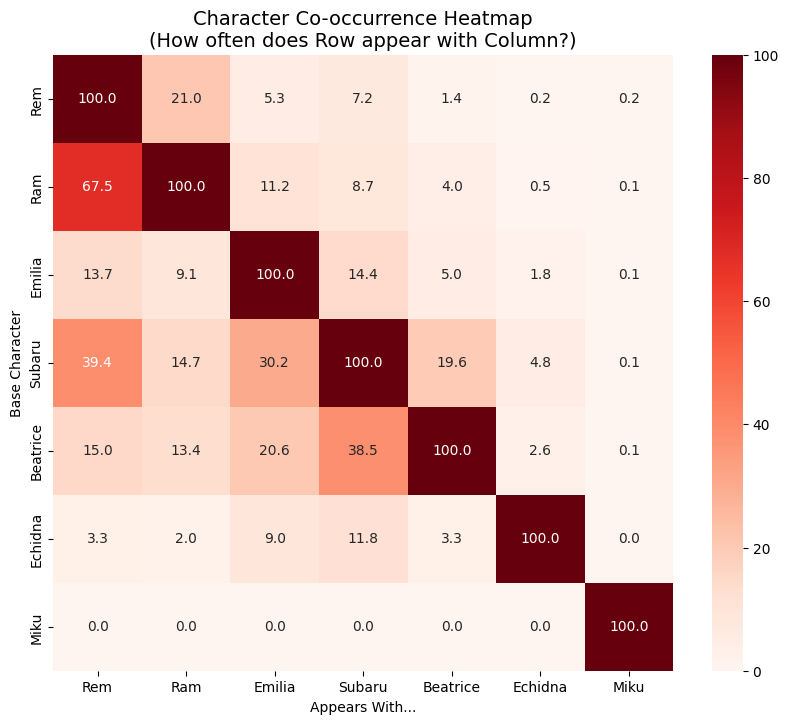

In [13]:
matrix_chars = {
    "Rem": "rem_(re:zero)",
    "Ram": "ram_(re:zero)",
    "Emilia": "emilia_(re:zero)",
    "Subaru": "natsuki_subaru",
    "Beatrice": "beatrice_(re:zero)",
    "Echidna": "echidna_(re:zero)",
    "Miku": "hatsune_miku"  # we expect this to be minimum as she is not in the same anime
}

labels = list(matrix_chars.keys())
tags = list(matrix_chars.values())
n = len(labels)
heatmap_data = pd.DataFrame(index=labels, columns=labels, dtype=float)

for row_label, row_tag in matrix_chars.items():
    # getting all images for the "Base" character
    mask_base = df['tag_string'].str.contains(row_tag, regex=False, na=False)
    base_indices = set(df.loc[mask_base].index)
    
    base_count = len(base_indices)
    
    for col_label, col_tag in matrix_chars.items():
        if base_count == 0:
            heatmap_data.loc[row_label, col_label] = 0.0
            continue

        mask_target = df['tag_string'].str.contains(col_tag, regex=False, na=False)
        target_indices = set(df.loc[mask_target].index)
        
        # calculating the intersection
        intersection = len(base_indices.intersection(target_indices))
        
        # percentage of co-occurrences
        pct = (intersection / base_count) * 100
        heatmap_data.loc[row_label, col_label] = pct

# plotting the Heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(heatmap_data, annot=True, fmt=".1f", cmap="Reds", vmin=0, vmax=100)

plt.title("Character Co-occurrence Heatmap\n(How often does Row appear with Column?)", fontsize=14)
plt.ylabel("Base Character")
plt.xlabel("Appears With...")

plt.show()

### 7. Evolution of Anime Hair Colors

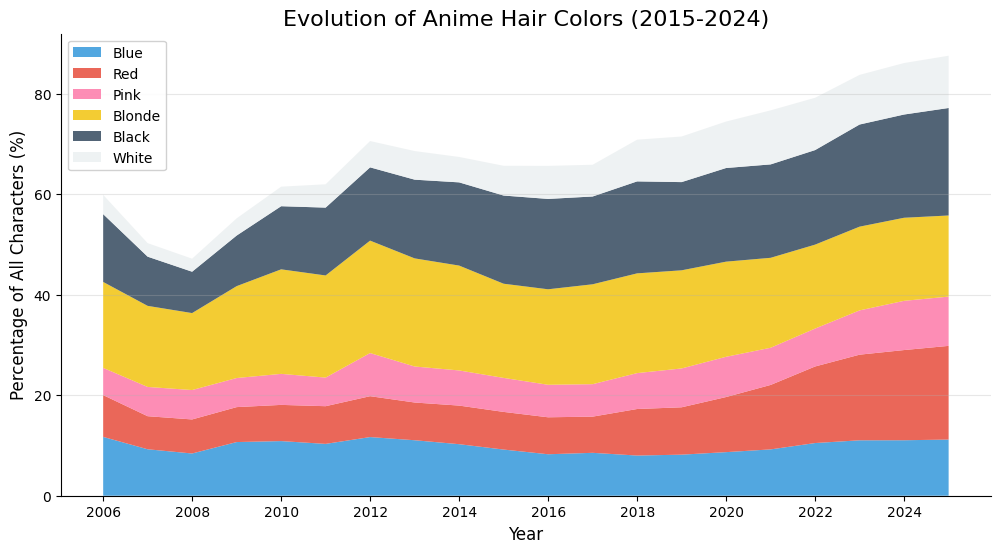

In [14]:
colors = {
    'Blue': 'blue_hair', 
    'Red': 'red_hair', 
    'Pink': 'pink_hair', 
    'Blonde': 'blonde_hair', 
    'Black': 'black_hair', 
    'White': 'white_hair'
}
labels = list(colors.keys())
tags = list(colors.values())
color_hex = ['#3498db', '#e74c3c', '#fd79a8', '#f1c40f', '#34495e', '#ecf0f1']

# resampling by Year
yearly_data = pd.DataFrame()

# we need the total count per year to normalize
total_art = df.set_index('created_at').resample('YE').size()

for label, tag in colors.items():
    mask = df['tag_string'].str.contains(tag, regex=False, na=False)
    counts = df.loc[mask].set_index('created_at').resample('YE').size()
    normalized = (counts / total_art) * 100
    yearly_data[label] = normalized

#handling NaN
yearly_data = yearly_data.fillna(0)

# stacked area chart
plt.figure(figsize=(12, 6))
plt.stackplot(yearly_data.index, yearly_data.T, labels=labels, colors=color_hex, alpha=0.85)

plt.title('Evolution of Anime Hair Colors (2015-2024)', fontsize=16)
plt.ylabel('Percentage of All Characters (%)', fontsize=12)
plt.xlabel('Year', fontsize=12)
plt.legend(loc='upper left', frameon=True, facecolor='white', framealpha=0.9)
plt.grid(axis='y', alpha=0.3)
ax = plt.gca()
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
plt.show()

In [15]:
target_year = 2012
target_tag = "black_hair"
start_date = f"{target_year}-01-01"
end_date = f"{target_year}-12-31"

mask = (
    (df['created_at'] >= start_date) & 
    (df['created_at'] <= end_date) & 
    (df['tag_string'].str.contains(target_tag, regex=False, na=False))
)
subset = df.loc[mask]

print(f"Found {len(subset):,} images with '{target_tag}' in {target_year}.")

# counting co-occurring characters
all_tags = " ".join(subset['tag_string'].dropna()).split()
counts = Counter(all_tags)

top_drivers = []

print(f"\\nTop 10 Character Drivers for {target_year}:")
print("-" * 40)

# filtering and printing
rank = 1
for tag, count in counts.most_common(2000):
    if tag == target_tag: continue # skipping the tag itself
    if tag in SPECIFIC_BANS: continue # using our existing cleaning lists
    
    is_vip = tag in VIPS
    has_parens = '_(' in tag and tag.endswith(')')
    
    if is_vip or has_parens:
        if not tag.endswith(BAD_SUFFIXES):
            clean_name = tag.split('_(')[0].replace('_', ' ').title()
            print(f"{rank}. {clean_name:<20} ({count} images)")
            top_drivers.append(tag)
            rank += 1
    
    if rank > 10:
        break

Found 40,117 images with 'black_hair' in 2012.
\nTop 10 Character Drivers for 2012:
----------------------------------------
1. Hakurei Reimu        (1237 images)
2. Akemi Homura         (875 images)
3. Konpaku Youmu        (743 images)
4. Diarmuid Ua Duibhne  (713 images)
5. Artoria Pendragon    (547 images)
6. Saber                (534 images)
7. Konpaku Youmu        (501 images)
8. Kirisame Marisa      (423 images)
9. Iskandar             (370 images)
10. Genderswap           (323 images)
